<center><h2><b>AI ENGINEERING ASSIGNMENT: EASEL AI</b></h2></center>
<center><h4><b>GARMENT MASKING PIPELINE</b></h4></center>
<center><h4><b><i>Radhika Patel</i></b></h4></center>

### **SETUP**

Please download the following models and place them in the models/ folder:
- [PSPNet](https://drive.google.com/drive/folders/1ZOZ9hU3LEADvyR25Orur9mGkkpN8drY5)
- [SHCP (LIP)](https://drive.google.com/file/d/1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH/view)
- [SHCP (Pascal)](https://drive.google.com/file/d/1E5YwNKW2VOEayK9mWCS3Kpsxf-3z04ZE/view)
  

Visualizing garment and pose images from under the sample-data/ directory, retrieved from google images and from given assignment. 

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from collections import OrderedDict

import torch
import torchvision
import torchvision.transforms as T

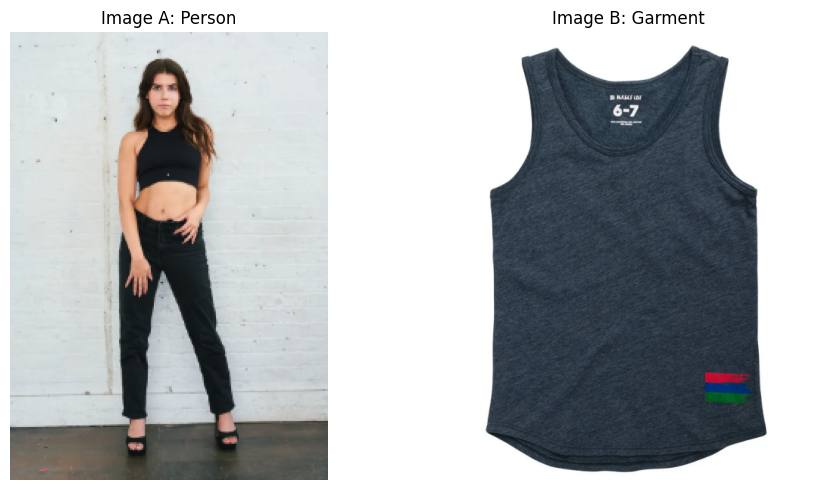

In [26]:
'''
CHANGE THE FOLLOWING TO EXPERIMENT WITH THE DESIRED MODEL IMAGE AND GARMENT TYPE
'''
######################
person = "pose1" 
garment = "tank-top"
######################

person_path = f"sample-data/poses/{person}.png"   
garment_path = f"sample-data/garments/{garment}.png" 

garment_categories = ["long-sleeve-t-shirt", "short-sleeve-t-shirt", "pants", "short-dress", "long-dress", "short-skirt", \
                      "long-skirt", "shorts", "blouse", "crop-top", "tank-top"]

img_person = Image.open(person_path).convert("RGB")
img_garment = Image.open(garment_path).convert("RGB")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img_person)
axs[0].set_title("Image A: Person")
axs[1].imshow(img_garment)
axs[1].set_title("Image B: Garment")
for ax in axs: ax.axis("off")
plt.tight_layout()
plt.show()


## **GARMENT CLASSIFICATION USING CLIP**

Step-1 of our pipeline involves identifying to the garment type that the person/model needs to try on. The classifications will provide the backbone for building the logic needed to create our final masks. 

I chose to use CLIP for garment classification because of its ability to perform zero-shot predictions using simple text prompts, which allowed me to avoid training a dedicated fashion classifier. Unlike traditional CNNs or models like ResNet or EfficientNet, which require labeled fashion datasets and retraining, CLIP can generalize well to unseen garment types and styles. Its flexibility made it ideal for my pipeline, where the garments varied in category, cut, and appearance. While alternatives like FashionNet or fine-tuned ViTs could have offered more precision, CLIP provided a lightweight, plug-and-play solution that balanced ease of use with robust performance.

In [28]:
# Uncomment and run the line below if the clip import gives an error in the cell below
#!pip install git+https://github.com/openai/CLIP.git

In [29]:
import clip

def get_garment_class(garment_path): 

    # Loading Model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)
    
    # Defining garment category prompts
    text_inputs = torch.cat([clip.tokenize(f"a photo of a {g}") for g in garment_categories]).to(device)

    # Loading and preprocessing garment image
    img = Image.open(garment_path).convert("RGB")
    image_input = preprocess(img).unsqueeze(0).to(device)
    
    # Inference using CLIP
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)
    
        logits_per_image, _ = model(image_input, text_inputs)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    
    for i, cat in enumerate(garment_categories):
        print(f"{cat:>12}: {probs[0][i]*100:.2f}%")
    
    garment_type = garment_categories[np.argmax(probs)]
    print("\nPredicted Garment Type:", garment_type)

    return garment_type

get_garment_class(garment_path)

long-sleeve-t-shirt: 1.39%
short-sleeve-t-shirt: 10.78%
       pants: 0.00%
 short-dress: 0.00%
  long-dress: 0.00%
 short-skirt: 0.00%
  long-skirt: 0.00%
      shorts: 0.02%
      blouse: 0.00%
    crop-top: 0.29%
    tank-top: 87.50%

Predicted Garment Type: tank-top


'tank-top'

## **HUMAN SEGMENTATION**

In [5]:
# Define preprocessing transforms for input images 
# (used for both SCHP and PSPNet models trained on the LIP dataset)
transform = T.Compose([
    T.Resize((473, 473), interpolation=Image.BILINEAR),  # LIP default input size
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# Label index mapping used by LIP dataset (20-class semantic segmentation)
# Each index corresponds to a specific human part or clothing region
LIP_LABELS = {
     0: 'Background', 1: 'Hat', 2: 'Hair', 3: 'Glove', 4: 'Sunglasses',
     5: 'Upper-clothes', 6: 'Dress', 7: 'Coat', 8: 'Socks', 9: 'Pants',
    10: 'Jumpsuits', 11: 'Scarf', 12: 'Skirt', 13: 'Face', 14: 'Left-arm',
    15: 'Right-arm', 16: 'Left-leg', 17: 'Right-leg', 18: 'Left-shoe', 19: 'Right-shoe'
}

#### **SINGLE-HUMAN-PARSING-LIP Model**

Reference: https://github.com/Yukun-Huang/Single-Human-Parsing-LIP?tab=readme-ov-file

I looked into several  human segmentation models, and the Single Human Parsing LIP model referenced above stood out for its fine-grained labeling across 20 categories. Its ability to run without requiring CUDA made it especially enticing during early development. It provided detailed segmentation of body parts and garments, which was ideal for my use case. However, the predictions did not prove to be reliable, we can see how a significant portion of the background gets mislabelled as "upper-clothes" along with several mix-matches in the final output mask. 

In [6]:
import sys
sys.path.append('Single-Human-Parsing-LIP')

In [7]:
from net.pspnet import PSPNet

def load_pspnet_model(checkpoint_path, num_classes=20, backend='resnet50'):
    
    model = PSPNet(n_classes=num_classes, backend=backend, pretrained=False)
    
    raw_ckpt = torch.load(checkpoint_path, map_location='cuda')
    clean_state_dict = OrderedDict(
        (k.replace("module.", ""), v) for k, v in raw_ckpt.items()
    )
    model.load_state_dict(clean_state_dict)
    model.eval()
    return model

checkpoint_path = "models/PSPNet_last"
model = load_pspnet_model(checkpoint_path)

torch.save(model.state_dict(), "models/PSPNet_cleaned.pth")
model.load_state_dict(torch.load("models/PSPNet_cleaned.pth"))
model.eval()

print("PSPNet model loaded and ready for inference.")


PSPNet model loaded and ready for inference.


Segmentation logits shape: torch.Size([1, 20, 480, 480])
Prediction map shape: (480, 480)


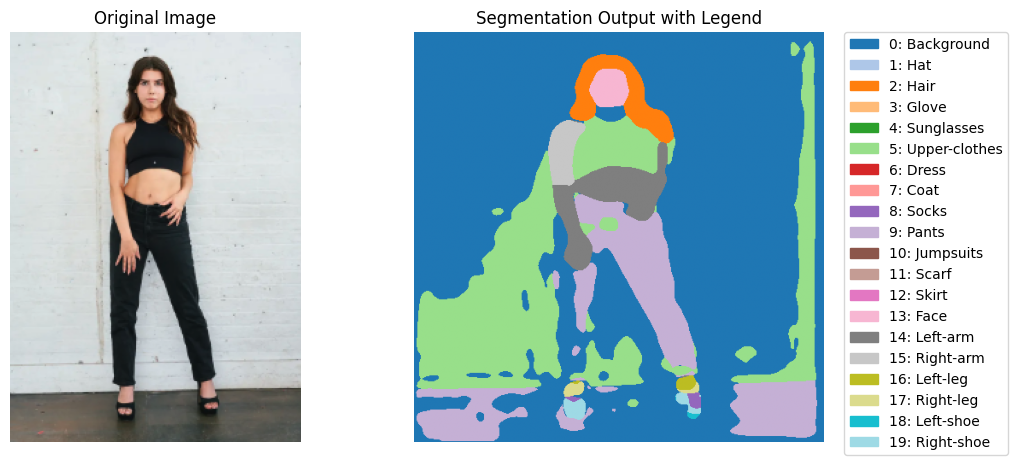

In [8]:
import matplotlib.patches as mpatches

input_tensor = transform(img_person).unsqueeze(0)  # add batch dim

# Inference
with torch.no_grad():
    output = model(input_tensor)
    logits = output[0]
    print("Segmentation logits shape:", logits.shape)
    pred = torch.argmax(logits.squeeze(), dim=0).cpu().numpy()
    print("Prediction map shape:", pred.shape)

# Creating a color map
cmap = plt.get_cmap('tab20', 20)  # tab20 has 20 distinct colors
patches = [mpatches.Patch(color=cmap(i), label=f"{i}: {LIP_LABELS[i]}") for i in range(20)]

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_person)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(pred, cmap=cmap, vmin=0, vmax=19)
plt.title("Segmentation Output")
plt.axis("off")
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()


#### **SEGMENTATION USING SELF CORRECTION HUMAN PARSING**

https://github.com/GoGoDuck912/Self-Correction-Human-Parsing?tab=readme-ov-file

After observing the limitations of the Single Human Parsing LIP model, I explored Self-Correction for Human Parsing (SCHP), which builds on LIP with a stronger backbone and self-correction mechanisms to refine predictions across multiple stages. SCHP offered promising results in the literature, with a higher mIoU on the popular LIP dataset and visually improved segmentation quality. The refinement stages and robustness to varied poses and garments made it an attractive option for my pipeline. Despite the additional complexity of setting up the SCHP environment and requiring CUDA for optimal performance, the potential for more accurate and coherent segmentation made it the best bet for improving mask quality. I tried two pretrained models to assess which one would more better robustness in terms of building the final garment masking logic. The model trained on the LIP dataset performs segmentation over 20 classes which include a mix of clothing and body-part classes. The model trained on the Pascal dataset does so over 7 classes - all pertaining directly to human body parts, ignoring the clothing the person is wearing. 

##### **USING MODEL PRETRAINED ON LIP**

In [30]:
import sys
sys.path.append("Self-Correction-Human-Parsing")

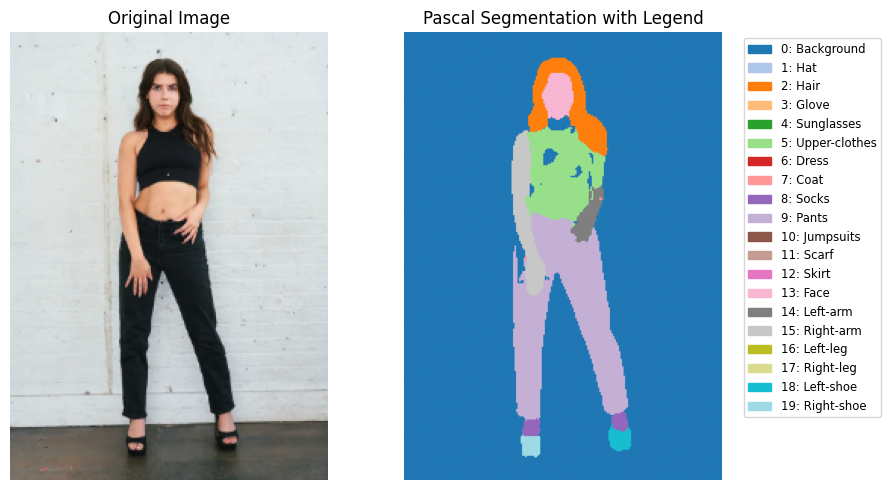

In [31]:
# --- SCHP repo imports ---
from networks import init_model
from utils.transforms import transform_logits


# Function to load SCHP model
def load_schp_model(checkpoint_path, num_classes=20):

    # Needed to reformat model state dict for compatibility
    
    model = init_model('resnet101', num_classes=num_classes, pretrained=None)
    checkpoint = torch.load(checkpoint_path, map_location='cuda')
    state_dict = checkpoint["state_dict"]

    # Remove 'module.' prefix
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k.replace("module.", "")
        new_state_dict[name] = v

    model.load_state_dict(new_state_dict)
    model = model.cuda().eval()
    return model

# Perform human segmentation using SCHP model
def get_segmentation(image_path, model, labels=LIP_LABELS, plot=False):
    image = Image.open(image_path).convert('RGB')
    orig_size = image.size
    input_tensor = transform(image).unsqueeze(0).cuda()

    with torch.no_grad():
        outputs = model(input_tensor)
        logits = outputs[0][0]

        import torch.nn.functional as F
        logits = F.interpolate(logits, size=orig_size[::-1], mode='bilinear', align_corners=True)
        parsing = torch.argmax(logits.squeeze(0), dim=0).cpu().numpy()

    num_classes = len(labels)
    cmap = plt.get_cmap('tab20', num_classes)
    parsing_rgb = cmap(parsing / (num_classes - 1))[:, :, :3]  # Drop alpha channel

    if plot: 
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis("off")
    
        plt.subplot(1, 2, 2)
        plt.imshow(parsing_rgb)
        plt.title("Pascal Segmentation with Legend")
        plt.axis("off")
        patches = [
            mpatches.Patch(color=cmap(i / (num_classes - 1)), label=f"{i}: {labels[i]}")
            for i in range(num_classes)
        ]
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
        plt.tight_layout()
        plt.show()

    return parsing


# Load model
lip_model = load_schp_model("models/exp-schp-201908261155-lip.pth")

# Get segmentation and visualize output
lip_segmentation_map = get_segmentation(person_path, lip_model, LIP_LABELS, plot=True)


##### **USING MODEL PRETRAINED ON PASCAL**

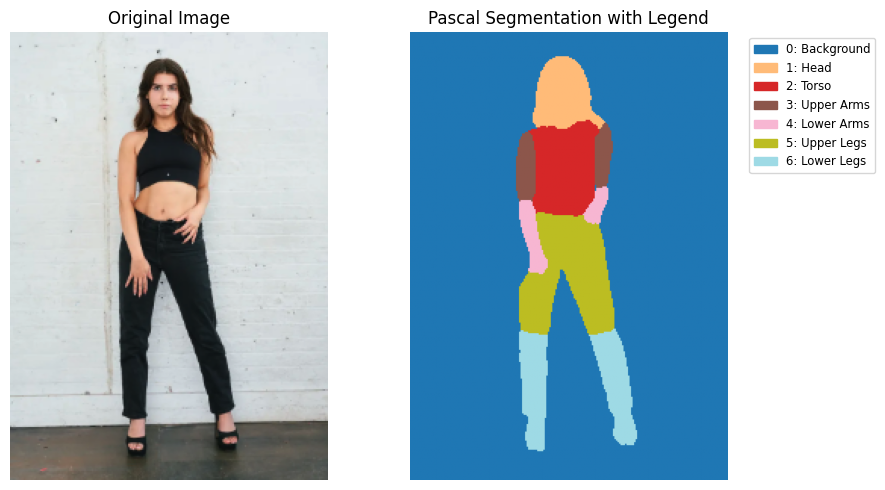

In [14]:
# Pascal-Person-Part: 7 labels
PASCAL_LABELS = {
    0: "Background",
    1: "Head",
    2: "Torso",
    3: "Upper Arms",
    4: "Lower Arms",
    5: "Upper Legs",
    6: "Lower Legs",
}

# --- Load and Run ---
pascal_model = load_schp_model("models/exp-schp-201908270938-pascal-person-part.pth", num_classes=7)

person_path = "sample-data/poses/pose1.png"   
pascal_segmentation_map = get_segmentation(person_path, pascal_model, PASCAL_LABELS, plot=True)


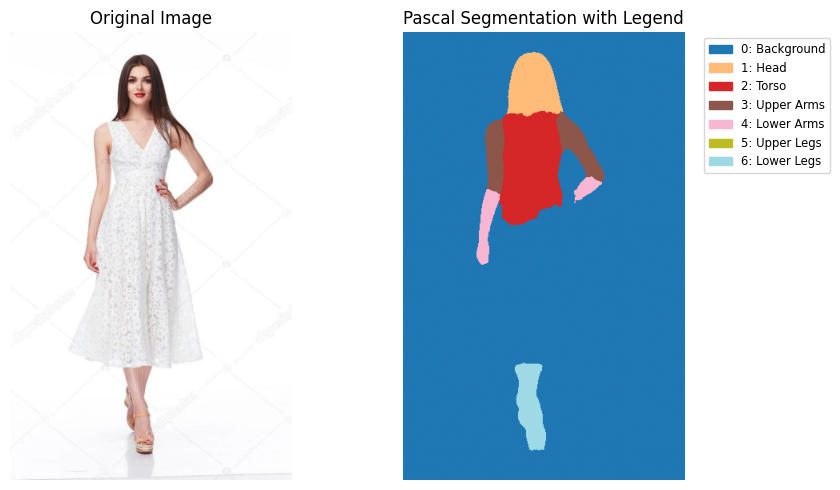

In [32]:
person_path = "sample-data/poses/pose6.png"   
pascal_segmentation_map = get_segmentation(person_path, pascal_model, PASCAL_LABELS, plot=True)

As we can see, the Pascal-based model fails to address edge cases like above where the contour of the human body parts are not directly seen. We will stick with the LIP-based pretrained model for now.

**BRAINSTORMING MAKSING LOGIC**

This was my intuitive reasoning behind using the logic above: 
- In general, if the model is wearing a single piece (like a dress/jumpsuit), we would most likely want to mask the entire piece regardless of whether or not they are trying on a single piece or any top/bottom. 
- If the person is wearing a two-piece outfit:
    - If they are trying on a top:
      - We want to mask all parts of their top outfit. If they are trying on a long sleeve item, we would have to mask the arms as well.
    - If they are trying on a bottom
      - We want to mask all parts of the bottom they are currently wearing. If their legs are displayed, and the model is trying on a full length bottom, we want to mask the parts classified as 'legs' as well. 

In [38]:
LABEL_NAMES_TO_IDX = {v.lower(): k for k, v in LIP_LABELS.items()}

# --- Garment-specific mask decision logic ---
def extract_garment_mask_decision_tree(parsing, garment_name):
    garment_name = garment_name.lower()
    unique_labels = np.unique(parsing)

    def detected(label):  # Check if a category is present
        return LABEL_NAMES_TO_IDX[label] in unique_labels

    mask_labels = set()

    if garment_name == "short-sleeve-t-shirt" or garment_name == "long-sleeve-t-shirt":
        for cat in ["upper-clothes", "dress", "jumpsuits"]:
            if detected(cat):
                mask_labels.add(LABEL_NAMES_TO_IDX[cat])
            if garment_name == "long-sleeve-t-shirt": 
                for arm in ["left-arm", "right-arm"]:
                    if detected(arm):
                        mask_labels.add(LABEL_NAMES_TO_IDX[arm])

    elif garment_name in ["short-dress", "long-dress"]:
        if detected("upper-clothes"):
            mask_labels.add(LABEL_NAMES_TO_IDX["upper-clothes"])
            if detected("pants"):
                mask_labels.add(LABEL_NAMES_TO_IDX["pants"])
            if detected("skirt"):
                mask_labels.add(LABEL_NAMES_TO_IDX["skirt"])
        elif detected("dress"):
            mask_labels.add(LABEL_NAMES_TO_IDX["dress"])
        elif detected("jumpsuits"):
            mask_labels.add(LABEL_NAMES_TO_IDX["jumpsuits"])
        if garment_name == "long-dress":
            for leg in ["left-leg", "right-leg"]:
                if detected(leg):
                    mask_labels.add(LABEL_NAMES_TO_IDX[leg])

    elif garment_name in ["pants", "shorts", "short-skirt", "long-skirt"]:
        if detected("pants"):
            mask_labels.add(LABEL_NAMES_TO_IDX["pants"])
        if detected("skirt"):
            mask_labels.add(LABEL_NAMES_TO_IDX["skirt"])
        if detected("dress"):
            mask_labels.add(LABEL_NAMES_TO_IDX["dress"])
        if detected("jumpsuits"):
            mask_labels.add(LABEL_NAMES_TO_IDX["jumpsuits"])
        if garment_name == "long-skirt" or garment_name == "pants":
            for leg in ["left-leg", "right-leg"]:
                if detected(leg):
                    mask_labels.add(LABEL_NAMES_TO_IDX[leg])

    elif garment_name in ["crop-top", "tank-top", "blouse"]:
        for cat in ["upper-clothes", "dress", "jumpsuits"]:
            if detected(cat):
                mask_labels.add(LABEL_NAMES_TO_IDX[cat])

    # Create the binary mask
    mask = np.isin(parsing, list(mask_labels)).astype(np.uint8) * 255
    return mask


In [39]:
def overlay_mask(image_np, mask):
    overlaid = image_np.copy()
    overlaid[mask == 255] = [128, 128, 128]  # gray out selected portions
    return overlaid

In [40]:
def get_results(person_path, garment_path):
    # Load images
    img_person = Image.open(person_path).convert("RGB")
    img_garment = Image.open(garment_path).convert("RGB")

    # Step 1: Display garment
    plt.figure(figsize=(5, 5))
    plt.imshow(img_garment)
    plt.axis("off")
    plt.title("Garment Image (CLIP Input)")
    plt.show()

    # Step 2: Get segmentation map
    segmentation_map = get_segmentation(person_path, lip_model, LIP_LABELS, plot=True)

    # Step 3: Predict garment class with CLIP
    garment_class = get_garment_class(garment_path)
    print(f"Predicted garment class (CLIP): {garment_class}")

    # Step 4: Generate decision-based garment mask
    garment_mask = extract_garment_mask_decision_tree(segmentation_map, garment_class)

    # Step 5: Overlay mask on person image
    overlay = overlay_mask(np.array(img_person), garment_mask)

    # Step 6: Final result
    plt.figure(figsize=(10, 5))
    plt.imshow(overlay)
    plt.title(f"Masked Output for: {garment_class}")
    plt.axis("off")
    plt.show()


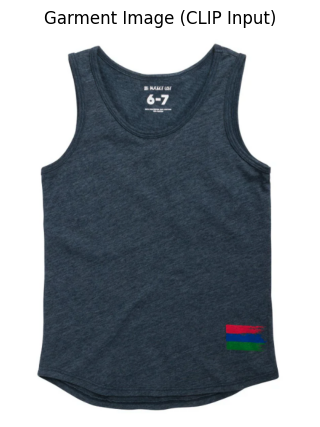

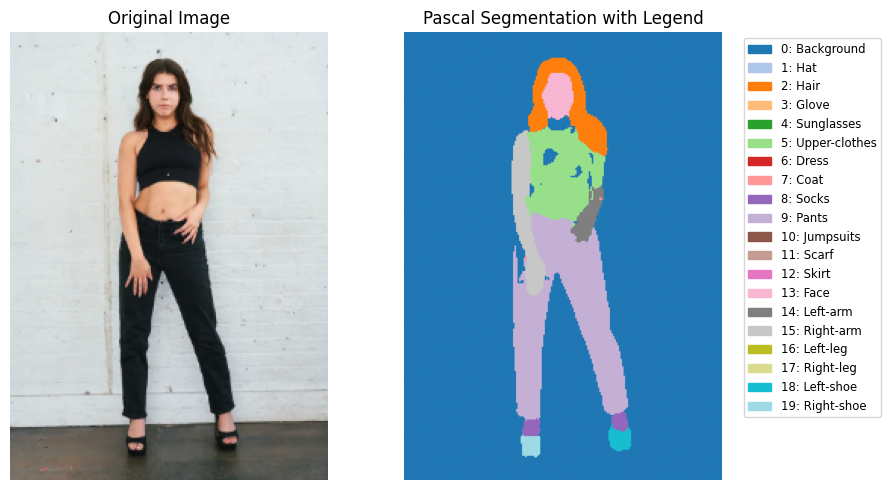

long-sleeve-t-shirt: 1.39%
short-sleeve-t-shirt: 10.78%
       pants: 0.00%
 short-dress: 0.00%
  long-dress: 0.00%
 short-skirt: 0.00%
  long-skirt: 0.00%
      shorts: 0.02%
      blouse: 0.00%
    crop-top: 0.29%
    tank-top: 87.50%

Predicted Garment Type: tank-top
Predicted garment class (CLIP): tank-top


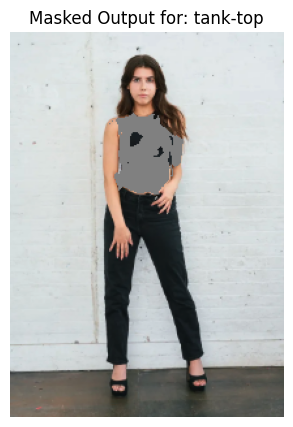

In [41]:
person_path = "sample-data/poses/pose1.png"
garment_path = "sample-data/garments/tank-top.png"
get_results(person_path, garment_path)


The "tank-top" masks over the "upper-clothes" just fine in this case. 

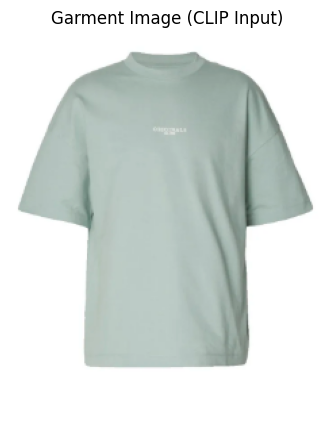

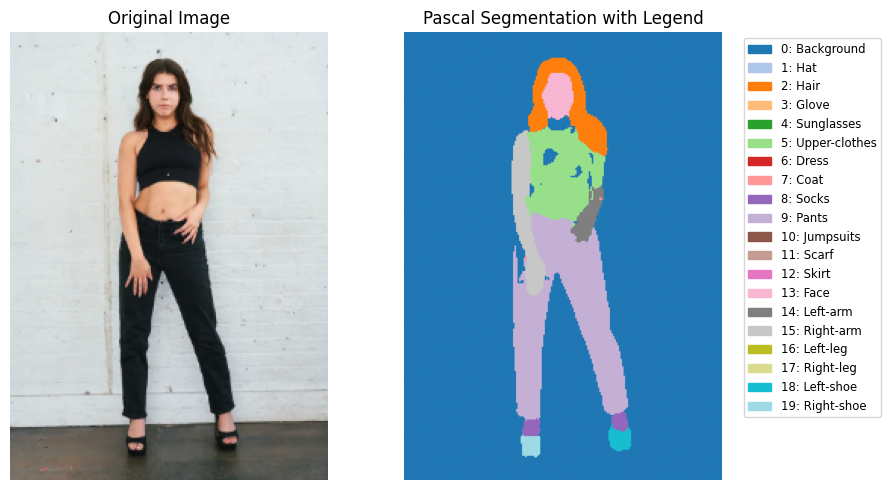

long-sleeve-t-shirt: 33.69%
short-sleeve-t-shirt: 65.97%
       pants: 0.01%
 short-dress: 0.00%
  long-dress: 0.00%
 short-skirt: 0.00%
  long-skirt: 0.00%
      shorts: 0.01%
      blouse: 0.06%
    crop-top: 0.20%
    tank-top: 0.03%

Predicted Garment Type: short-sleeve-t-shirt
Predicted garment class (CLIP): short-sleeve-t-shirt


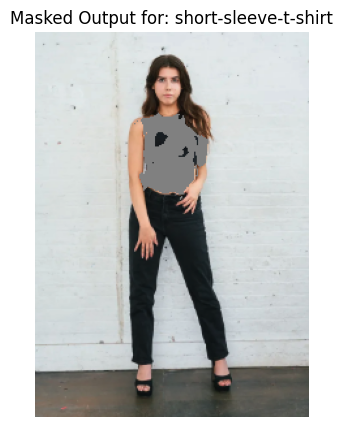

In [42]:
person_path = "sample-data/poses/pose1.png"
garment_path = "sample-data/garments/tshirt.png"
get_results(person_path, garment_path)

In this case, the model's segmentation of the upper garment excluded the short sleeves for the short-sleeve tshirt, due to limitations in the variety of laebls used in the LIP dataset. In hindsight, I could have addressed this by manually expanding the mask to include adjacent arm regions or using a separate arm segmentation heuristic based on geometry. Another option would be to fine-tune the segmentation model on examples with diverse sleeve lengths to better capture such edge cases.

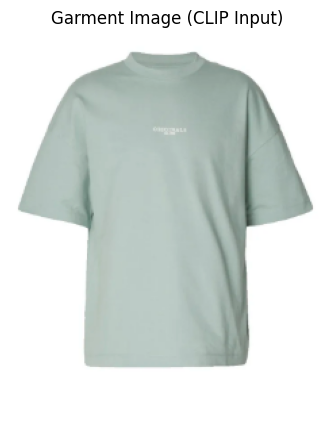

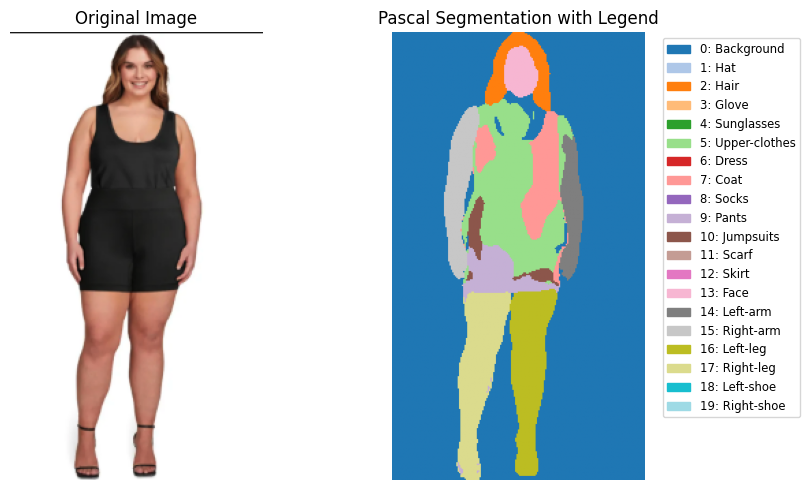

long-sleeve-t-shirt: 33.69%
short-sleeve-t-shirt: 65.97%
       pants: 0.01%
 short-dress: 0.00%
  long-dress: 0.00%
 short-skirt: 0.00%
  long-skirt: 0.00%
      shorts: 0.01%
      blouse: 0.06%
    crop-top: 0.20%
    tank-top: 0.03%

Predicted Garment Type: short-sleeve-t-shirt
Predicted garment class (CLIP): short-sleeve-t-shirt


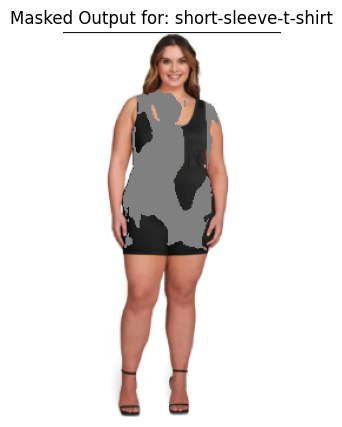

In [45]:
person_path = "sample-data/poses/pose2.png"
garment_path = "sample-data/garments/tshirt.png"
get_results(person_path, garment_path)

The human segmentation mask in this case failed short in classifying the different parts of the model's clothing body parts, inherently not providing the foundation for implementing the masking logic. In the best case scenrio, only the top would have been masked along with the top-half of the model's arms.

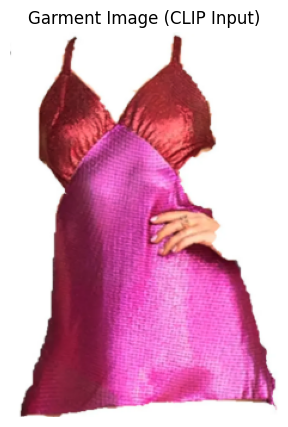

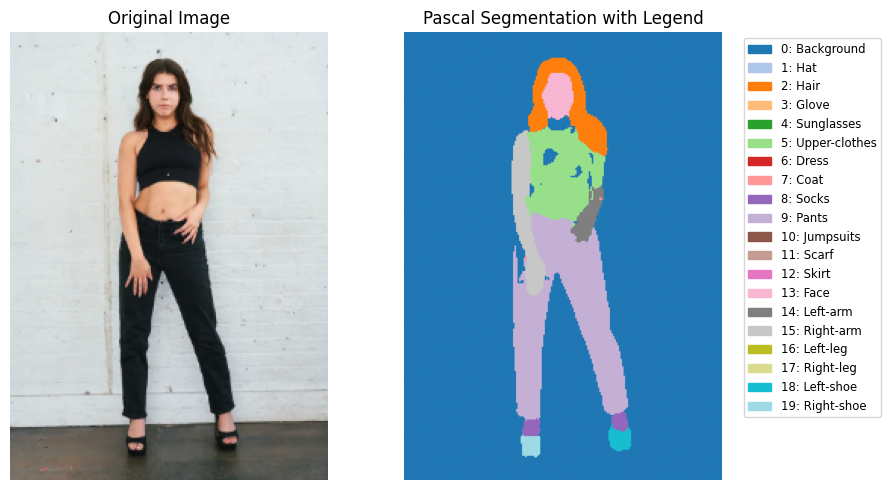

long-sleeve-t-shirt: 0.14%
short-sleeve-t-shirt: 0.19%
       pants: 0.97%
 short-dress: 49.88%
  long-dress: 20.79%
 short-skirt: 7.42%
  long-skirt: 8.94%
      shorts: 0.50%
      blouse: 4.94%
    crop-top: 2.52%
    tank-top: 3.73%

Predicted Garment Type: short-dress
Predicted garment class (CLIP): short-dress


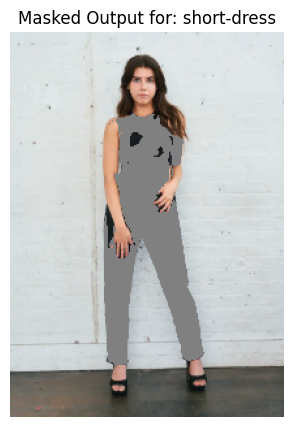

In [46]:
person_path = "sample-data/poses/pose1.png"
garment_path = "sample-data/garments/short-dress.png"
get_results(person_path, garment_path)

All clothing, including the full pants is masked here for the short dress to be augmented on the model. 

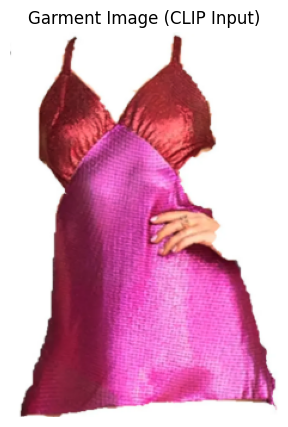

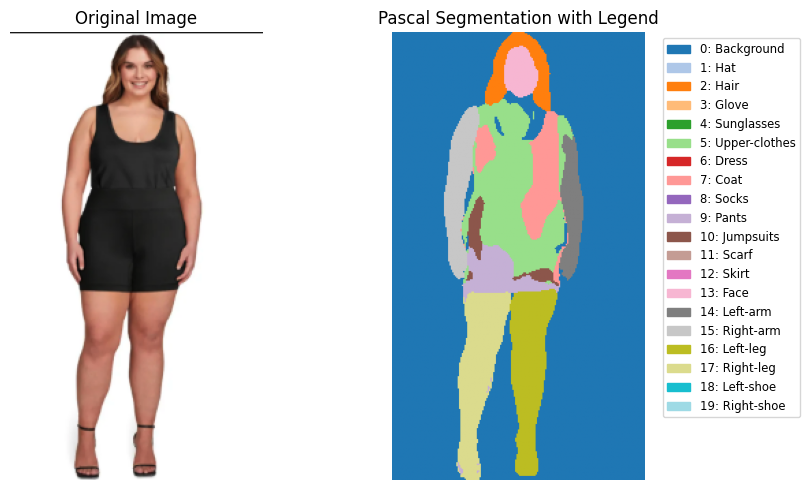

long-sleeve-t-shirt: 0.14%
short-sleeve-t-shirt: 0.19%
       pants: 0.97%
 short-dress: 49.88%
  long-dress: 20.79%
 short-skirt: 7.42%
  long-skirt: 8.94%
      shorts: 0.50%
      blouse: 4.94%
    crop-top: 2.52%
    tank-top: 3.73%

Predicted Garment Type: short-dress
Predicted garment class (CLIP): short-dress


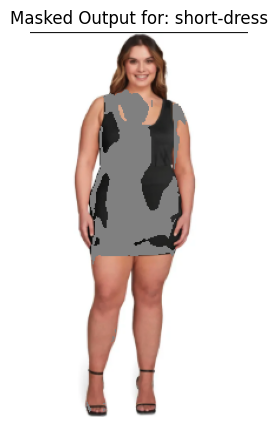

In [47]:
person_path = "sample-data/poses/pose2.png"
garment_path = "sample-data/garments/short-dress.png"
get_results(person_path, garment_path)

Both the top and bottom garments are covered here for the short dress to be augmented without covering the legs. The SCHP model does not provide the ideal base mask for segmenting the 'upper-clothes' and 'shorts'. 

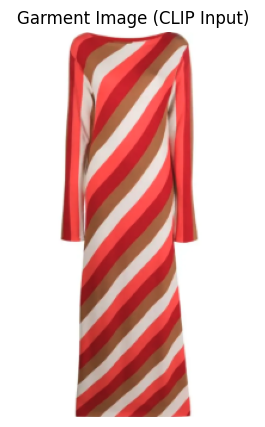

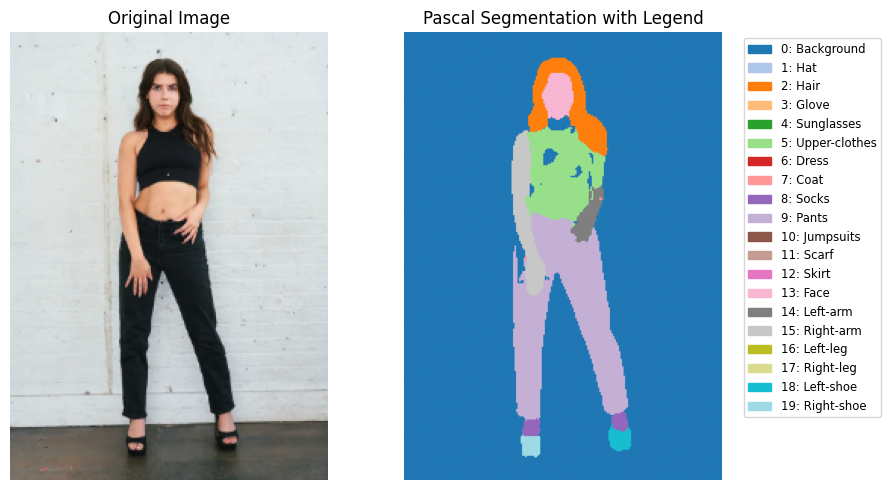

long-sleeve-t-shirt: 1.31%
short-sleeve-t-shirt: 2.38%
       pants: 1.66%
 short-dress: 10.49%
  long-dress: 50.05%
 short-skirt: 1.25%
  long-skirt: 29.44%
      shorts: 0.24%
      blouse: 2.65%
    crop-top: 0.14%
    tank-top: 0.36%

Predicted Garment Type: long-dress
Predicted garment class (CLIP): long-dress


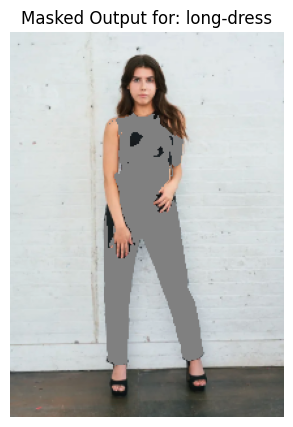

In [23]:
person_path = "sample-data/poses/pose1.png"
garment_path = "sample-data/garments/long-dress.png"
get_results(person_path, garment_path)

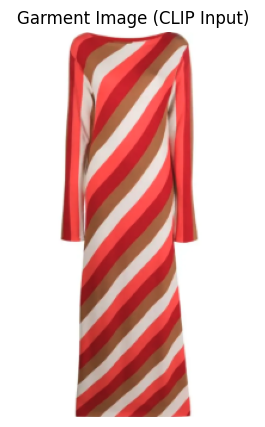

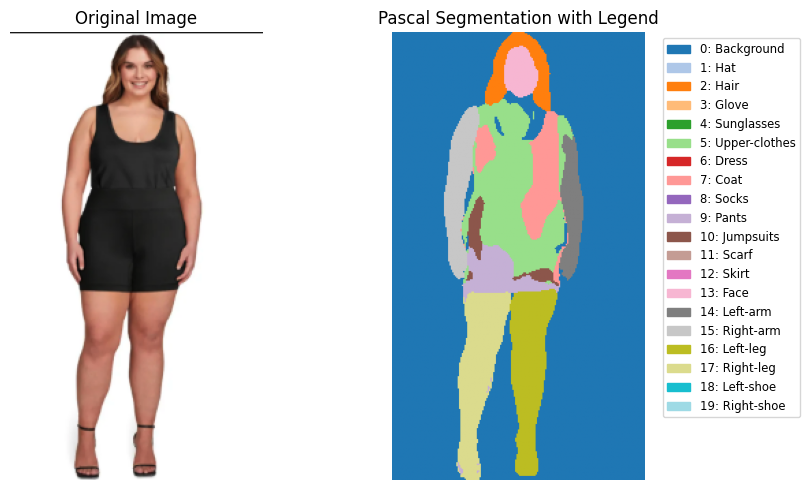

long-sleeve-t-shirt: 1.31%
short-sleeve-t-shirt: 2.38%
       pants: 1.66%
 short-dress: 10.49%
  long-dress: 50.05%
 short-skirt: 1.25%
  long-skirt: 29.44%
      shorts: 0.24%
      blouse: 2.65%
    crop-top: 0.14%
    tank-top: 0.36%

Predicted Garment Type: long-dress
Predicted garment class (CLIP): long-dress


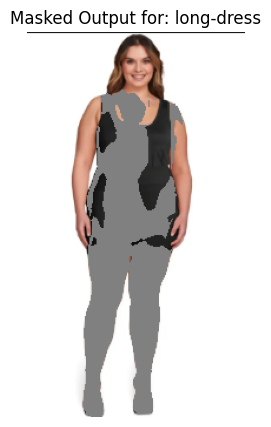

In [24]:
person_path = "sample-data/poses/pose2.png"
garment_path = "sample-data/garments/long-dress.png"
get_results(person_path, garment_path)

In both cases above, we can see the legs, along with the upper body are completely mask to reflect the augmentation of a full length dress. In hindsight we could manually/geometrically expand the mask in the bottom half to accomodate to the shape of the dress. In hindsight, I could have included more label diversity in the original clip-segmentation to classify long sleeve vs short sleeve dresses and then add logic to mask the right-arm and left-arm as well. 

### **REFLECTION AND FINAL THOUGHTS:**

To improve this project, one major direction would have been incorporating learning-based garment transfer methods. Unlike rule-based masking pipelines, these approaches use deep learning to synthesize how a garment would realistically appear on a target person. For instance, models like VITON, CP-VTON, and DressCode leverage image warping and generative adversarial networks (GANs) to deform, align, and blend garments onto a person's body while preserving texture and adapting to pose variations. These models are trained end-to-end on curated try-on datasets and handle challenges like occlusions, sleeve alignment, and garment-body interaction far more robustly than traditional segmentation-based approaches. While my current implementation focuses on static masking based on segmentation and garment classification, adopting a learning-based pipeline would have enabled more natural-looking try-on results. Additionally, fine-tuning segmentation models on a small, domain-specific dataset could have helped improve segmentation accuracy, especially for ambiguous clothing types like short-sleeve vs. long-sleeve tops. These extensions were outside the scope of this project (and the knowledge I gained while doing this project), but exploring them in the future would significantly elevate the fidelity of the virtual try-on experience

### **RESOURCES**

These are some additional references I came across when doing my study for implementing this project. This was a great learning experience. 

- [LIP Dataset](https://drive.google.com/drive/folders/1ZjNrTb7T_SsOdck76qDcd5OHkFEU0C6Q)
- [Kaggle Clothing Dataset](https://www.kaggle.com/datasets/agrigorev/clothing-dataset-full/data)
- [DeepFashion-in-shop-clothes-retrieval](https://www.kaggle.com/datasets/hserdaraltan/deepfashion-inshop-clothes-retrieval)
- [CE2P](https://github.com/liutinglt/CE2P?tab=readme-ov-file)
- [Human-Segmentation-PyTorch](https://github.com/thuyngch/Human-Segmentation-PyTorch?tab=readme-ov-file)
- [VITON](https://github.com/xthan/VITON/tree/master)
- [Awesome-Virtual-Try-Ons](https://github.com/minar09/awesome-virtual-try-on)
